# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run cell2location](#cell2location)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [6]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [6]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # for spatial mapping remove MT genes
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

Now let's look at QC: total number of counts and total number of genes per spot

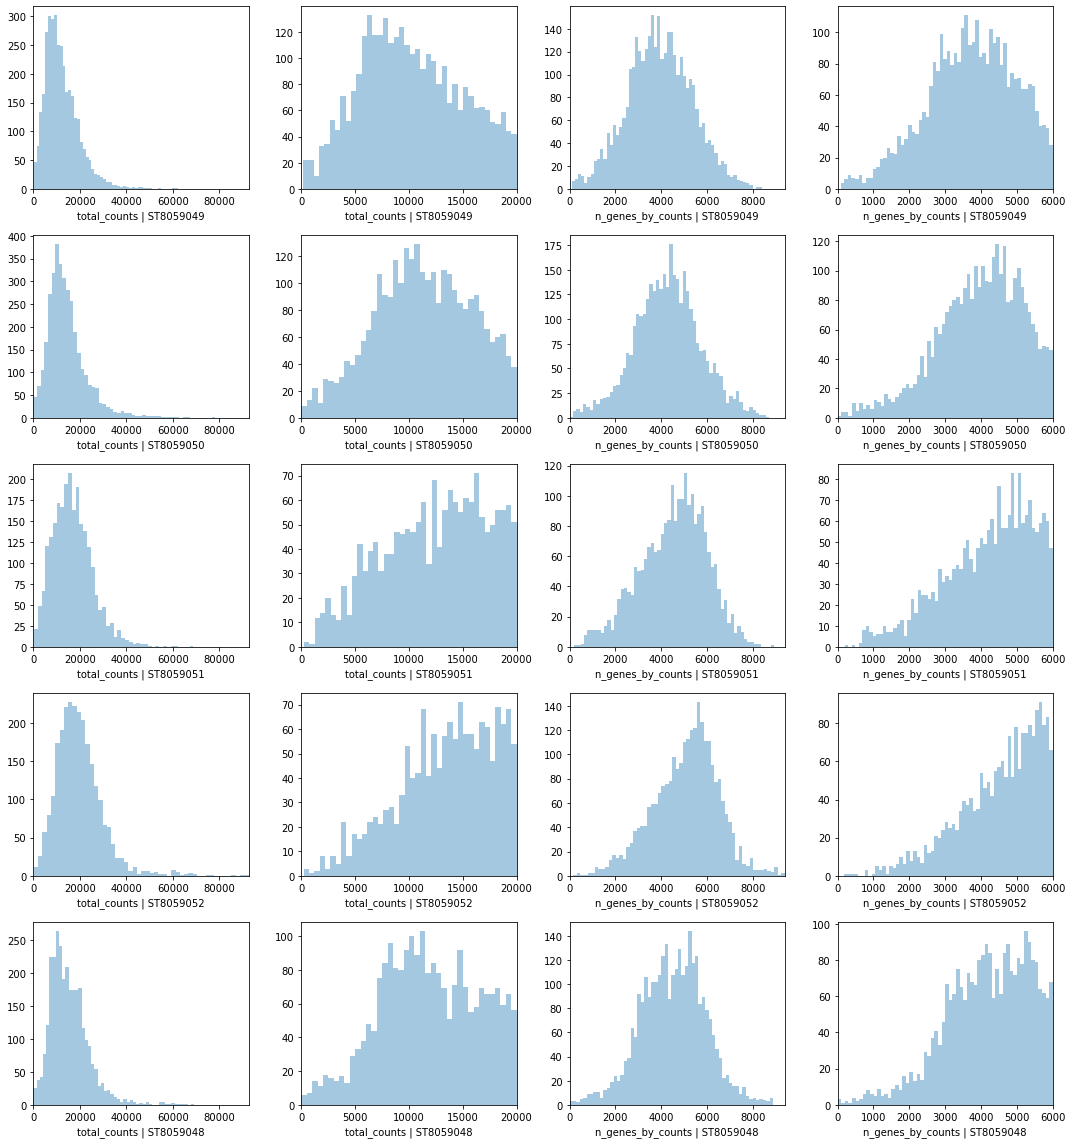

In [7]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


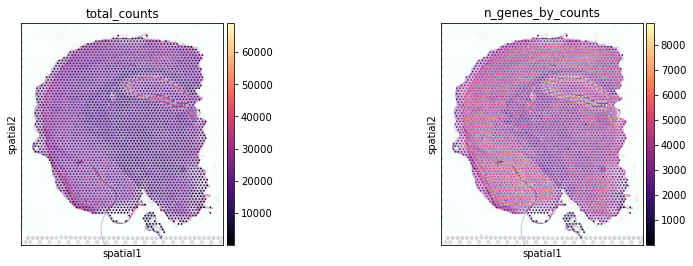

In [8]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


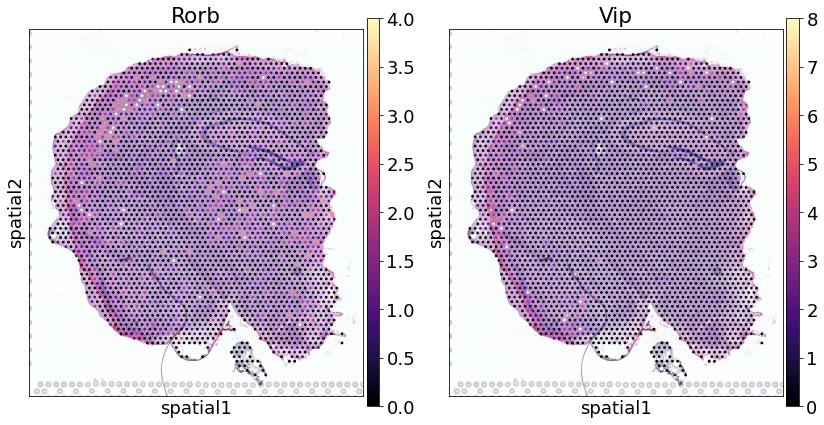

In [9]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :], 
              color=["Rorb", "Vip"], img_key='hires',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

In [ ]:
adata.raw = adata

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [7]:
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']

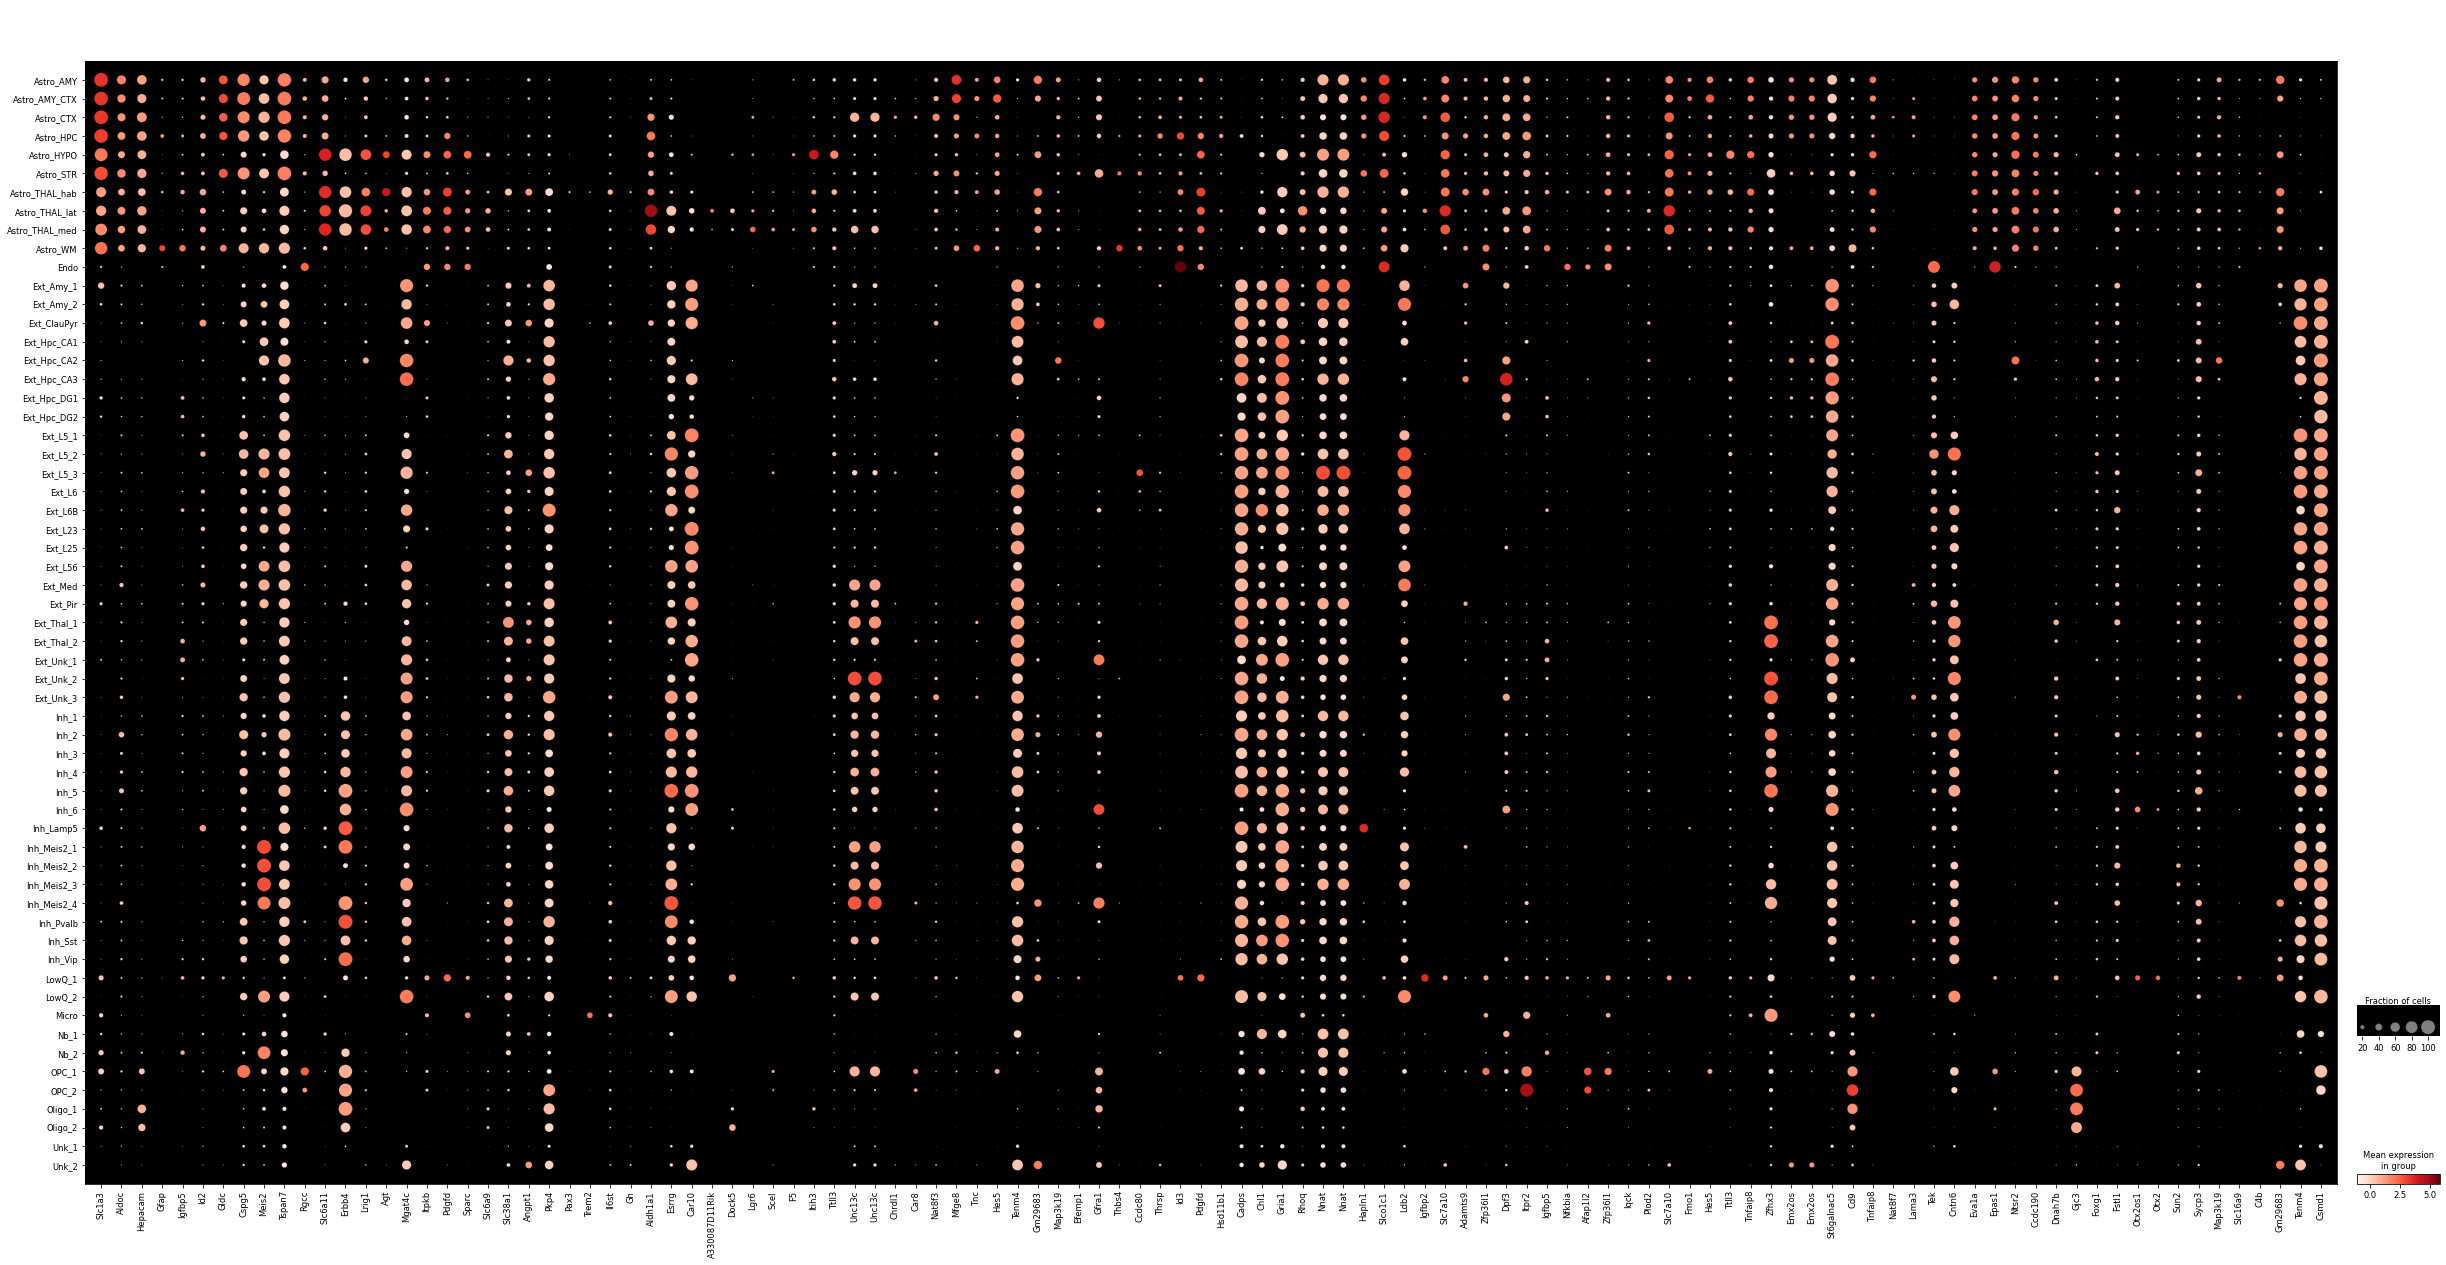

In [11]:
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{reg_path}marker_plots/'

gene_list = pd.read_csv(f'{reg_path}figures/Subtype_markers.csv', header=0)['Genes']
with matplotlib.rc_context({'axes.facecolor':  'black'}):
    sc.pl.dotplot(adata_snrna_raw, gene_list, groupby='annotation_1', 
                  gene_symbols='SYMBOL', use_raw=False, 
                  save=f'selected_panel.pdf', 
                  show=True);
sc.settings.figdir = sc_figpath

In [12]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_annotation_1_{i}' for i in adata_snrna_raw.obs['annotation_1'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_annotation_1_{i}', '', i) for i in adata_snrna_raw.obs['annotation_1'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [13]:
inf_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,0.006652,0.013381,0.009672,0.010551,0.016396,4.362995e-09,3.918688e-03,0.012995,0.020950,0.053045,...,6.475789,0.009182,2.363688,0.569750,2.202130,0.773202,2.177433,0.885846,1.399780,1.228170
ENSMUSG00000089699,0.001501,0.001095,0.002055,0.000696,0.003748,1.116136e-02,5.403521e-09,0.001581,0.001147,0.009992,...,1.259508,0.000859,0.512654,0.132410,0.383906,0.165249,0.423312,0.161883,0.227617,0.174571
ENSMUSG00000033845,0.114207,0.054338,0.085309,0.059021,0.066498,2.202430e-02,6.959011e-02,0.064746,0.104896,0.060093,...,0.214894,0.039218,0.108909,0.095944,0.084072,0.094551,0.077346,0.054940,0.041642,0.113457
ENSMUSG00000033813,0.088453,0.097077,0.129549,0.093324,0.080831,1.292675e-01,6.526587e-02,0.057145,0.082130,0.081030,...,0.194244,0.063650,0.084617,0.121712,0.108767,0.181124,0.140567,0.066971,0.013325,0.091371
ENSMUSG00000002459,3.596771,4.084791,4.167773,3.955367,1.140844,3.839240e+00,1.391272e+00,1.597041,1.308752,4.189671,...,0.062062,0.004818,0.133042,1.217572,0.614752,0.097037,0.037659,0.004848,0.107176,0.120861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000064370,0.154425,0.135329,0.106853,0.123680,0.061573,8.559838e-02,2.359829e-01,0.087570,0.072310,0.312812,...,0.184294,0.044913,0.130184,0.070209,0.112571,0.116551,0.049836,0.060489,0.038373,0.070576
ENSMUSG00000051412,0.042569,0.033413,0.051312,0.052405,0.043928,5.851342e-02,5.412691e-09,0.033294,0.038056,0.069674,...,0.083921,0.012877,0.063890,0.057759,0.083447,0.102482,0.096118,0.067913,0.023124,0.097860
ENSMUSG00000079834,0.233599,0.240260,0.301797,0.227757,0.257566,4.087606e-01,1.732663e-01,0.321039,0.316733,0.072512,...,0.189396,0.059993,0.077447,0.020228,0.286553,0.304142,0.255407,0.111864,0.034153,0.088070


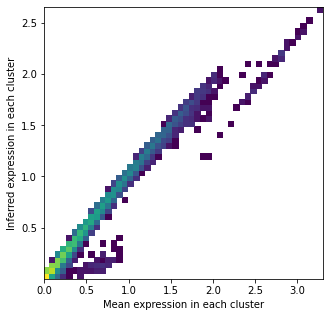

In [14]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

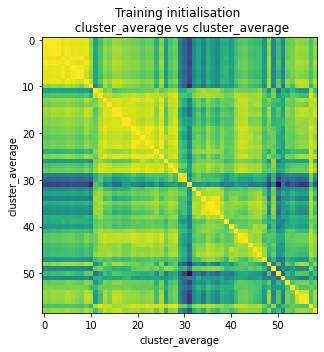

In [15]:
rcParams['figure.figsize'] = 5, 5
reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

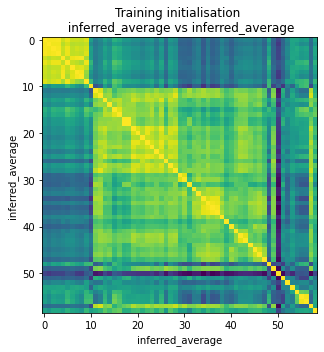

In [16]:
rcParams['figure.figsize'] = 5, 5
reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_average', 'inferred_average', align=False)

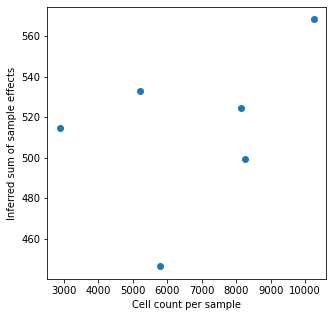

In [17]:
rcParams['figure.figsize'] = 5, 5
cell_count = adata_snrna_raw.obs['sample'].value_counts()
cell_count.index = ['mean_sample_effectsample_' + i for i in cell_count.index] 

soup_amount = reg_mod.sample_effects.sum(0) 
plt.scatter(cell_count[soup_amount.index].values.flatten(),
            soup_amount.values.flatten());
plt.xlabel('Cell count per sample'); # fraction of reads in cells
plt.ylabel('Inferred sum of sample effects');

In [19]:
reg_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/'

In [20]:
! ~/gdrive upload --parent 1jNobI0AtQw7tZ8mJ9SZp3FisA3dSbkzf --recursive /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/

Creating directory RegressionNBV2Torch_65covariates_40532cells_12819genes
Creating directory figures
Creating directory .ipynb_checkpoints
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/figures/Subtype_markers.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/figures/umapFig2B_UMAP_print.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/figures/umapFig2B_broad_UMAP.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/regression_model/RegressionNBV2Torch_65covariates_40532cells_12819genes/figures/umapFig3A_astro_UMAP.pdf
Uploading 

### Run cell2location <a class="anchor" id="cell2location"></a>

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [32]:
results_folder + 'std_model/'

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/'

In [ ]:
r = cell2location.run_cell2location(
                      sc_data=inf_aver, 
                      sp_data=adata,
    
                      verbose=True, return_all=False,
                      
                      summ_sc_data_args={'cluster_col': "annotation_1"},
                                      
                      train_args={'use_raw': True,
                                  'n_iter': 30000, 'learning_rate': 0.005,
                                  'sample_prior': False, # set to false for large spatial data 
                                  'readable_var_name_col': None,
                                  'sample_name_col': 'sample'},
                                      
                      posterior_args={'n_samples': 1000},
                                      
                      export_args={'path': results_folder + 'std_model/', 
                                   'run_name_suffix': '_n_comb50_mean_var5_inferred_30k',
                                   'save_model': False,
                                   'scanpy_coords_name': 'spatial', 'export_q05': True},
    
                      model_kwargs={ # Prior on the number of cells, cell types and co-located combinations
          
                    'cell_number_prior': {
                        # Use visual inspection of the tissue image to determine 
                        # the average number of cells per spot,
                        # an approximate count is good enough:
                        'cells_per_spot': 8, 
                        # Prior on the number of cell types (or factors) in each spot
                        'factors_per_spot': 9, 
                        # Prior on the number of correlated cell type combinations in each spot
                        'combs_per_spot': 5
                    },
          
                     # Prior on change in sensitivity between technologies
                    'gene_level_prior':{
                        # Prior on average change in expression level from scRNA-seq to spatial technology,
                        # this reflects your belief about the sensitivity of the technology in you experiment
                        'mean': 1/2, 
                        # Prior on how much individual genes differ from that average,
                        # a good choice of this value should be lower that the mean
                        'sd': 1/4
                    },
                          
                     # The number of co-located cell type combinations
                    'n_comb': 50, 'spot_fact_mean_var_ratio': 5,
                    'exper_gene_level_mean_var_ratio': 5
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.14 min
### Analysis name: CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k
### Training model ###


Finished [100%]: Average Loss = 1.5222e+08


Trained model object can be pulled from `r['mod']`, cell locations are added to `r['sp_data']` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are always saved to the results directory. 

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

Now we need to check if our model has trained successfully by looking at the loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by orders of magnitude.

#### Evaluating training

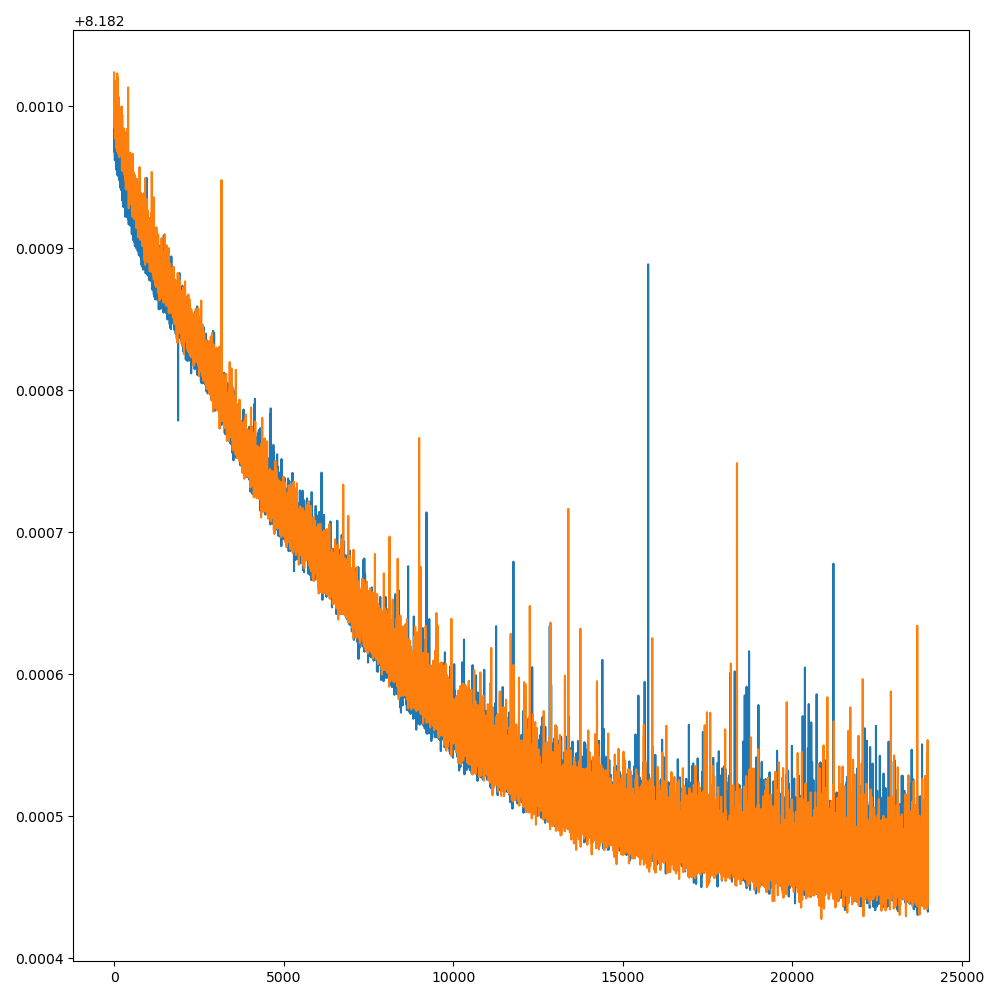

In [33]:
r = {'run_name': 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'}

from IPython.display import Image
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy or how well cell types and uniform background explain spatial data bu comparing expected value of the model (Poisson mean) to observed count of each gene across locations. The ideal case is perfect diagonal plot.

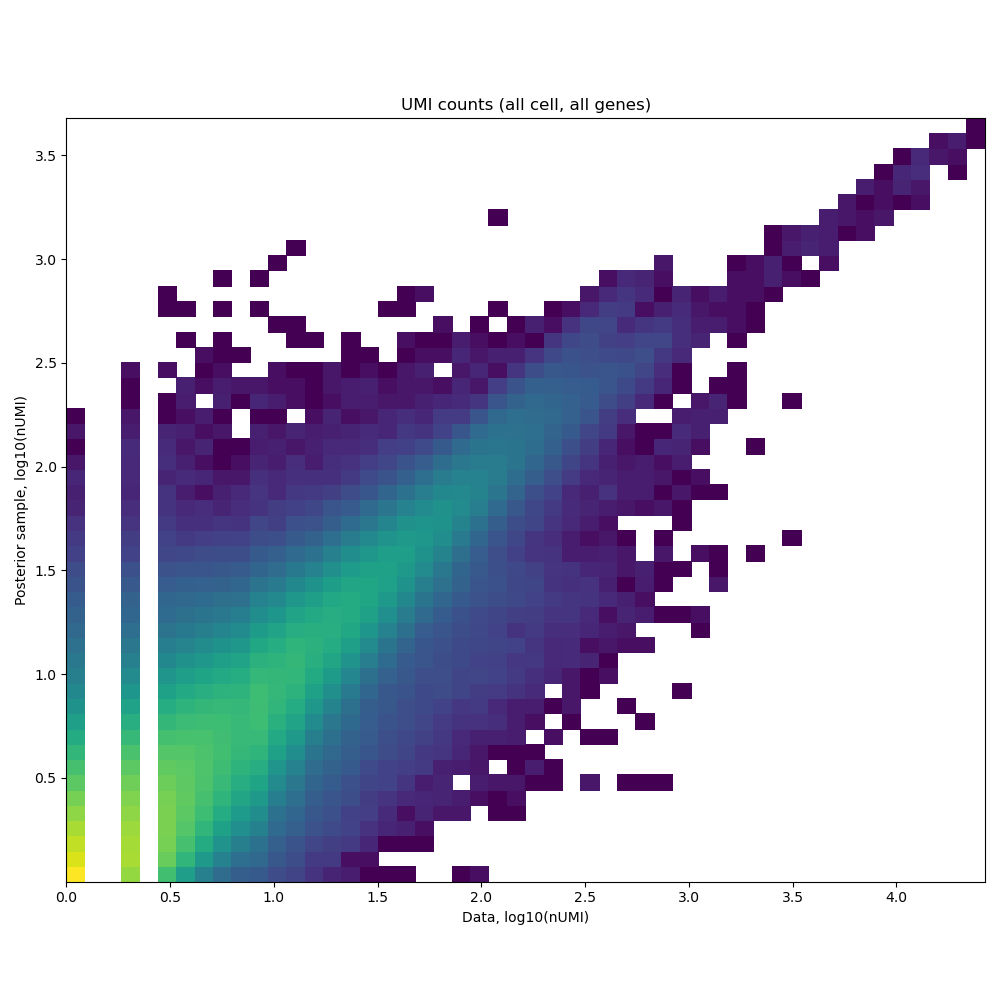

In [34]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of inferred locations between two independent training restarts.

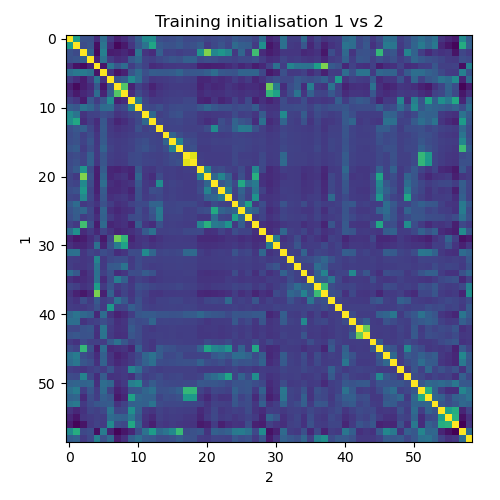

In [35]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/evaluate_stability.png',
      width=400)

#### Loading saved results

We can load our model and associated object after training (this also needs a GPU to be available and we need to know the analysis name):

```python
pickle_model = results_folder + 'std_model/'+r['run_name']+'/model_.p'
r = pickle.load(open(pickle_model, "rb"))

adata_vis = r['sp_data']
```

Alternatively we can load the results of the model saved into `sp_data`:

In [36]:
sp_data_file = results_folder + 'std_model/'+r['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

In [37]:
adata_vis.uns['mod']['post_sample_means']['phi_hyp'], adata_vis.uns['mod']['post_sample_sds']['phi_hyp']

(array([[2.613606]], dtype=float32), array([[0.0102605]], dtype=float32))

adata_vis.uns['mod']['post_sample_means']['phi_spot_hyp'], adata_vis.uns['mod']['post_sample_sds']['phi_spot_hyp']

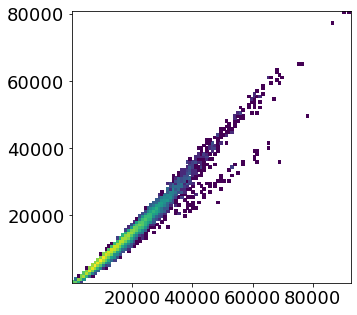

In [38]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [5,5]
plt.hist2d(adata_vis.obs['total_counts'].values,
           adata_vis.uns['mod']['post_sample_means']['nUMI_factors'].sum(1).flatten(),
           bins=100, norm=matplotlib.colors.LogNorm());

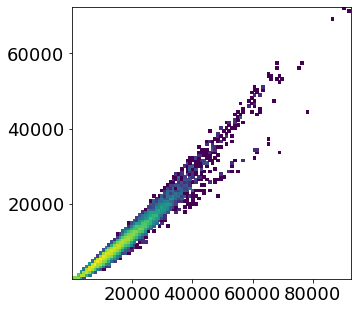

In [39]:
plt.hist2d(adata_vis.obs['total_counts'].values,
           adata_vis.uns['mod']['post_sample_q05']['nUMI_factors'].sum(1).flatten(),
           bins=100, norm=matplotlib.colors.LogNorm());

#### Advanced plotting of cell locations

Now we add cell locations to each slide to plot them over histology images.

In [40]:
col_sel = ['mean_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q05_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q95_nUMI_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['mean_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q05_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs
    
col_sel = ['q95_spot_factors' in i for i in adata_vis.obs.columns]
for s in slides.keys():
    obs = adata_vis.obs.loc[:,col_sel].loc[slides[s].obs.index,:]
    slides[s].obs[obs.columns] = obs

Here we visualise locations of multiple cell types at once.

In [307]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

In [1]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Region clustering cell densities <a class="anchor" id="region_clustering"></a>

We find regions by clustering spots based on inferred molecule contributions of each cell type. We use leiden clustering that incorporates both the similarity of spots in cell locations and in their proximity, by including both when computing the KNN graph. Results are saved in `adata_vis.obs['leiden']`.

In [113]:
sample_type = 'mean_spot_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 38)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.3)

In [114]:
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

Trying to set attribute `.uns` of view, copying.


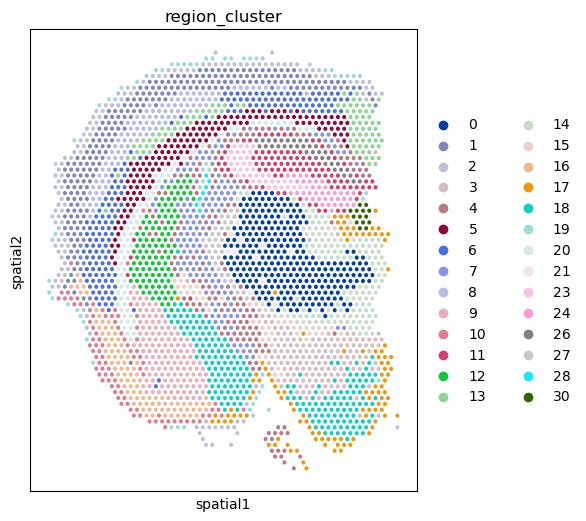

Trying to set attribute `.uns` of view, copying.


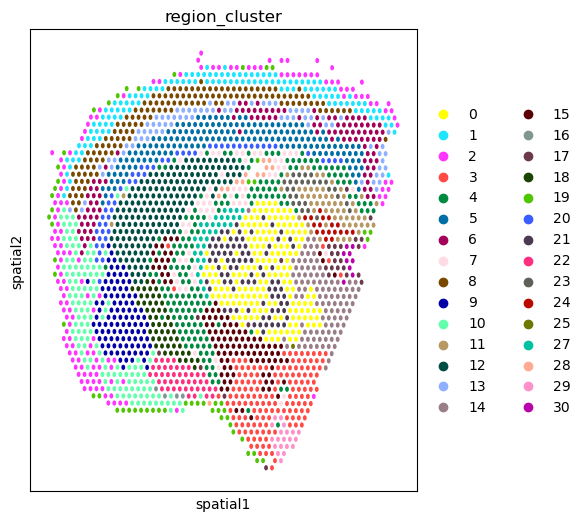

Trying to set attribute `.uns` of view, copying.


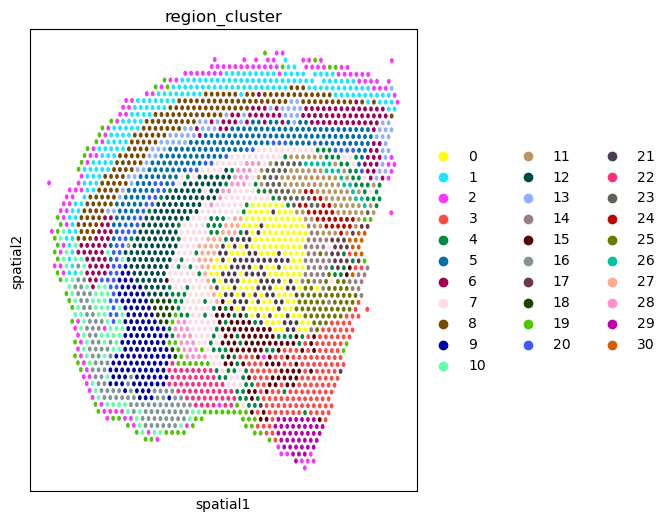

In [115]:
rcParams["figure.figsize"] = [5,6]
rcParams["axes.facecolor"] = "white"
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059048"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            );
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059051"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            )
sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059052"], 
              color=["region_cluster"], img_key=None,
              color_map=matplotlib.cm.get_cmap('Spectral')
            )

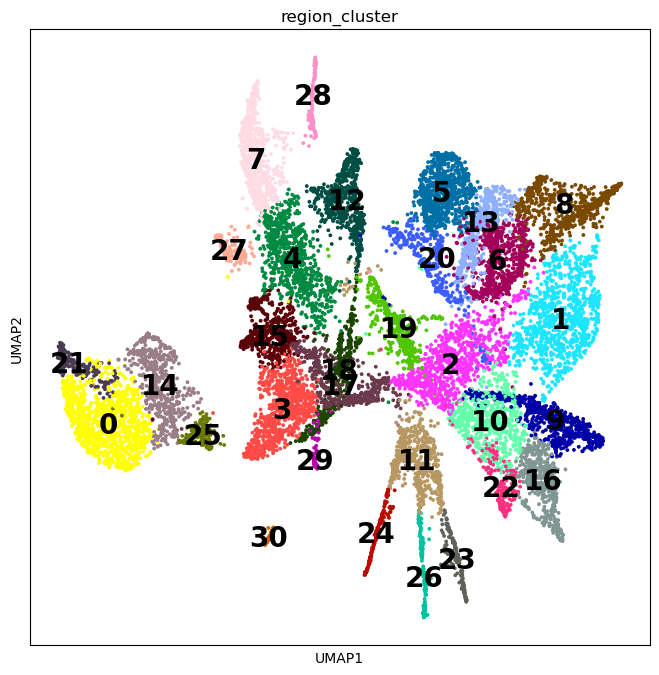

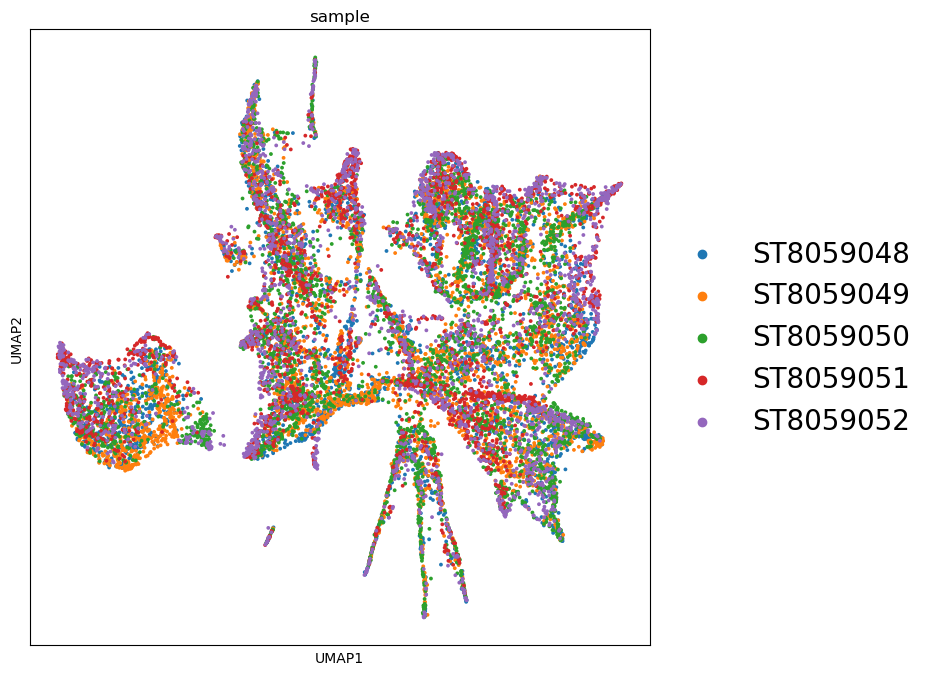

In [128]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

rcParams['figure.figsize'] = 8, 8
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=20)
sc.pl.umap(adata_vis, color=['sample'], size=30,
           color_map = 'RdPu', ncols = 2, #legend_loc='on data',
           legend_fontsize=20)

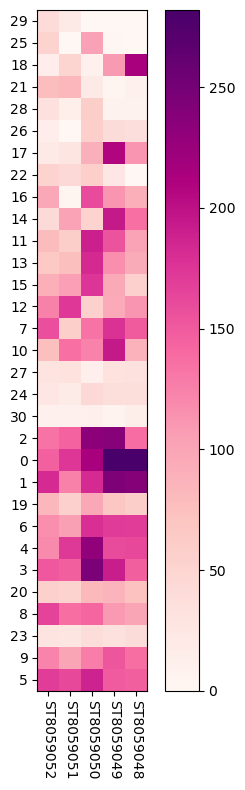

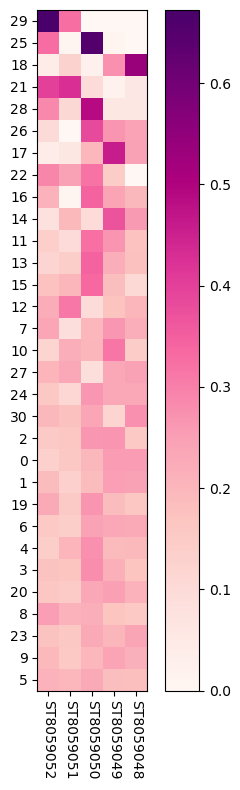

In [117]:
# check which clusters are in which section

def count_locations(adata, sample, cluster):
    
    return (adata.obs['sample'].isin([sample]) & adata.obs['region_cluster'].isin([cluster])).sum()
    
count_mat = [[count_locations(adata_vis, i, j) 
              for i in adata_vis.obs['sample'].unique()]
             for j in adata_vis.obs['region_cluster'].unique()]
count_df = pd.DataFrame(count_mat, index=adata_vis.obs['region_cluster'].unique(), 
                        columns=adata_vis.obs['sample'].unique())
count_fraq_df = (count_df.T / count_df.sum(1)).T

from scipy.stats import entropy
count_ent = entropy(count_fraq_df, base=2, axis=1)
count_df = count_df.iloc[np.argsort(count_ent),:]
count_fraq_df = count_fraq_df.iloc[np.argsort(count_ent),:]

from cell2location.plt.plot_heatmap import clustermap
clustermap(count_df, figure_size=[4, 8], cluster_rows=False, cluster_cols=False)
clustermap(count_fraq_df, figure_size=[4, 8], cluster_rows=False, cluster_cols=False)

In [133]:
# load old regions (Suppl table)
r = {'run_name': 'CoLocationModelNB4E3V2_59clusters_14968locations_12809genes_n_comb100_mean_var5_inferred_30k'}

sp_data_file = results_folder + 'std_model/'+r['run_name']+'/sp_with_clusters.h5ad'
adata_vis_old = anndata.read(sp_data_file)

adata_vis.obs['old_regions'] = adata_vis_old.obs['']

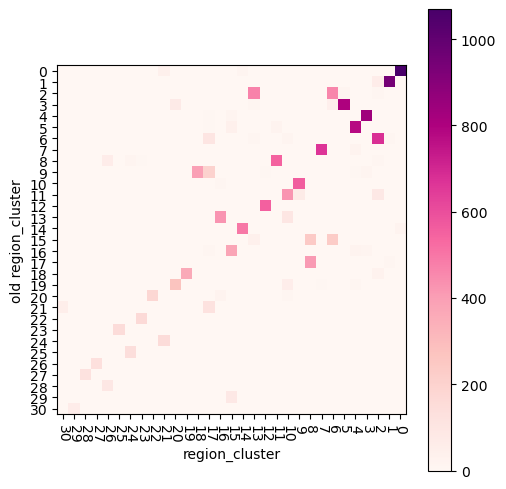

In [148]:
adata_vis.obs['old_regions'] = adata_vis_old.obs['region_cluster'][adata_vis.obs_names]
table = pd.pivot_table(adata_vis.obs, values='Astro_AMY', 
                       index='old_regions', columns='region_cluster', 
                       aggfunc=len, fill_value=0)

from cell2location.plt.plot_heatmap import clustermap
clustermap(table, cluster_cols=False, cluster_rows=False)
plt.xlabel('region_cluster');
plt.ylabel('old region_cluster');

### Export regions for import to 10X Loupe Browser <a class="anchor" id="loupe"></a>

In [118]:
# add binary labels for each region
region_cluster_bin = pd.get_dummies(adata_vis.obs['region_cluster'], columns=['region_cluster']).values
colnames = adata_vis.obs['region_cluster'].cat.categories
colnames = ['r' + str(i) for i in colnames]
region_cluster_bin = pd.DataFrame(region_cluster_bin, index=adata_vis.obs_names,
                                  columns=colnames)
region_cluster_bin['region_cluster'] = adata_vis.obs['region_cluster']

In [119]:
# add binary labels for each region
region_cluster_bin = pd.get_dummies(adata_vis.obs['region_cluster'], columns=['region_cluster']).values
colnames = adata_vis.obs['region_cluster'].cat.categories
colnames = ['r' + str(i) for i in colnames]
region_cluster_bin = pd.DataFrame(region_cluster_bin, index=adata_vis.obs_names,
                                  columns=colnames)
region_cluster_bin['region_cluster'] = adata_vis.obs['region_cluster']

# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])

for i in np.unique(sam):
    
    s1 = region_cluster_bin.drop(columns = ['region_cluster'])
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    
    #w1 = r['mod'].spot_factors_df.loc[sam == i]
    #w1.index = [x[10:] for x in w1.index]
    
    s1.to_csv(results_folder + 'std_model/'+r['run_name'] + '/region_cluster29_' + i + '.csv')
    #w1.to_csv(results_folder + 'std_model/'+r['run_name'] + '/W_V7_V2_' + i + '.csv')

## Run diffusion maps <a class="anchor" id="diffmap"></a>

Here we use the diffusion maps approach to visualize cell type density gradients. This allows describing how cell composition of spots transitions as you move through the tissue and shows which tissue regions are connected in terms of their cell composition.

del adata_vis.uns['diffmap_evals']
del adata_vis.obsm['X_diffmap']

In [120]:
sc.tl.diffmap(adata_vis)

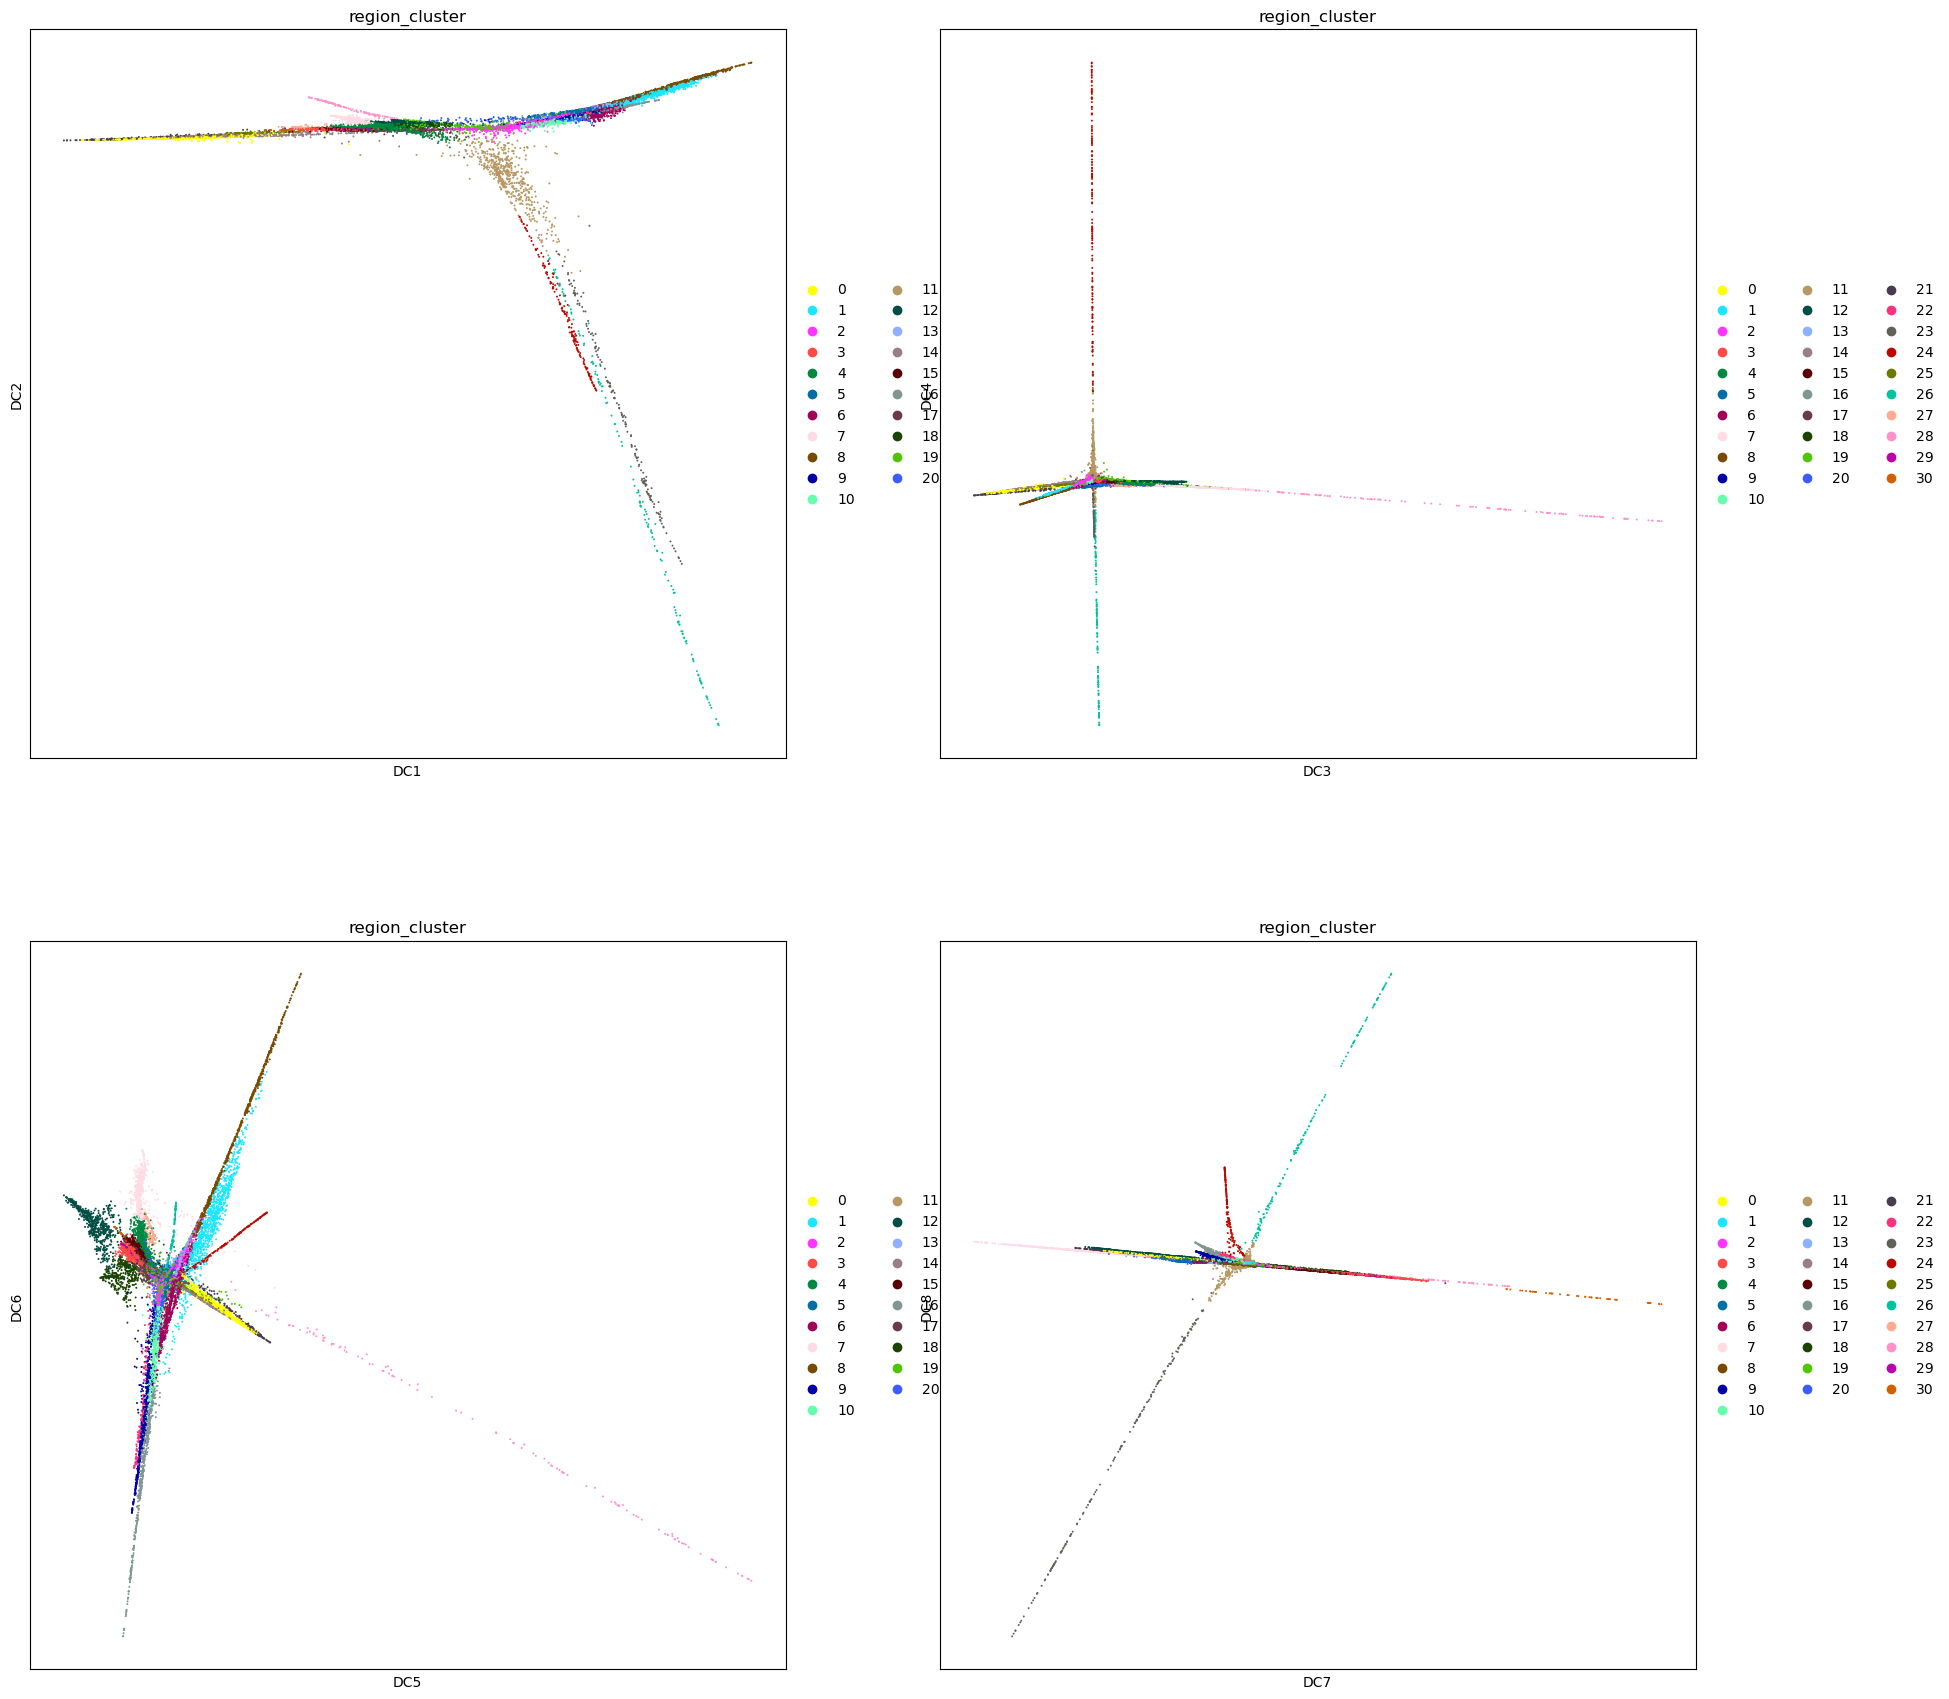

In [121]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [10,10]
sc.pl.diffmap(adata_vis, color=['region_cluster'],
              components=['1,2', '3,4', '5,6', '7,8'], ncols=2)

Save resulting adata with clustering and diffusion maps

In [122]:
adata_file = results_folder \
                + 'std_model/'+r['run_name']+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)

In [123]:
results_folder \
                + 'std_model/'+r['run_name']

'/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

## Run factorisation to find groups of cell types with similar location <a class="anchor" id="factorisation"></a>

In [336]:
matplotlib.rc_file_defaults()
plt.rcParams["axes.grid"] = False
# Run de-novo factorisation again
from cell2location import run_colocation
res_dict, sp_data = run_colocation(
                   adata_vis, model_name='CoLocatedCombination_sklearnNMF',
                   verbose=False, return_all=True,
    
                   train_args={'n_fact': np.arange(8, 30),
                               'n_iter': 20000,
                    'sample_name_col': 'sample',
                    'mode': 'normal', 'n_type': 'restart', 'n_restarts': 5},
    
                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.0001}},
    
                   posterior_args={},
                   export_args={'path': results_folder + 'std_model/'+r['run_name']+'/CoLocatedComb/',
                                'run_name_suffix': 'tol0.0001', 'plot_extension': 'pdf'})

### Analysis name: CoLocatedCombination_sklearnNMF_8combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_9combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_10combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_11combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_12combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_13combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_14combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_15combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_16combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_17combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_18combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_19combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_20combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_21combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_22combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_23combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_24combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_25combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_26combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_27combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_28combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


### Analysis name: CoLocatedCombination_sklearnNMF_29combinations_14968locations_59factorstol0.0001


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


Trying to set attribute `.obs` of view, copying.
... storing 'SSp_manual_layers' as categorical


... storing 'SSp_manual_layers' as categorical


In [339]:
! ~/gdrive upload --parent 1Lsxj9rzK4aHUaxDsReI7T6yjK_6flDWE --recursive /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/

Creating directory CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/region_cluster29_ST8059048.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/model_.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/W_mRNA_count.csv
Creating directory .ipynb_checkpoints             
Creating directory plots
Creating directory figures
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/plots/spatial/spatialhisto_W_mRNA_count_mean_ST8059052_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/plots/spatial/spatialW_cell_density_mean_ST8059050_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/plots/spatial/spatialhisto_W_cell_density_mean_ST8059052_p99.2.png
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/plo

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_mean/n_fact21.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_mean/n_fact9.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_mean/n_fact24.csv
Uploading /nfs/team205/vk7/sanger_projects/c

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_heatmap/n_fact28.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_heatmap/n_fact13.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/cell_type_fractions_heatmap/n_fact23.pdf
Uploading /nfs/team205/vk7/sanger_

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/cell_type_factors_n_fact29.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/cell_type_factors_n_fact11.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/cell_type_factors_n_fact24.pdf
Uploading /nfs/t

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/location_factors_n_fact13.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/cell_type_factors_n_fact19.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/stability_plots/cell_type_factors_n_fact17.pdf
Uploading /nfs/te

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/factor_markers/n_fact23.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/factor_markers/n_fact28.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/factor_markers/n_fact26.csv
Creating directory spatial
Uploading /nfs/team205/vk7/sanger_projects/cel

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact26_sST8059050_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact8_sST8059049_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact15_sST8059050_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact21_sST8059052_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mea

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact21_sST8059050_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mean_n_fact11_sST8059049_p99.2.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/spatial/spatialcell_density_mea

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/models/model_n_fact22.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/models/model_n_fact25.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/models/model_n_fact20.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/location_factors_mean/n_fact12.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/location_factors_mean/n_fact17.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/location_factors_mean/n_fact15.csv
Uploading /nfs/team205/vk7/sanger_projects/cell2loca

Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/predictive_accuracy/data_vs_posterior_mean_n_fact25.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/predictive_accuracy/data_vs_posterior_mean_n_fact10.pdf
Uploading /nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k/CoLocatedComb/CoLocatedCombination_sklearnNMF_14968locations_59factorstol0.0001/predictive_accuracy/data_vs_posterior_mean_n_

Modules and their versions used for this analysis

In [125]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.5
wcwidth 0.2.5
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.1
zmq.sugar.constants 40302
zmq.sugar.version 19.0.1
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.6
_curses b'2.2'
dateutil 2.8.1
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.1
numpy.core 1.19.1
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.1
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.2
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
natsort 7.0.1
pa